> **Copyright &copy; 2020 CertifAI Sdn. Bhd.**<br>
 **Copyright &copy; 2021 CertifAI Sdn. Bhd.**<br>
 <br>
This program and the accompanying materials are made available under the
terms of the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). \
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS, WITHOUT
WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the
License for the specific language governing permissions and limitations
under the License. <br>
<br>**SPDX-License-Identifier: Apache-2.0**> 

# 05 - Unsupervised Anomaly Detection Using LSTM

Authored by: [Kian Yang Lee](https://github.com/KianYang-Lee) - kianyang.lee@certifai.ai

## Notebook Description

This tutorial will showcase the application of long short-term memory (LSTM) network in anomaly detection. The deep learning framework to be used is `PyTorch`. An exercise section is attached for you to practice and hone your skills. Do make good use of it.

By the end of this tutorial, you will be able to:

1. Prepare time series data to be feed into deep learning model
2. Build and apply LSTM network on anomaly detection
3. Compare and contrast performance of anomaly detection algorithms

## Notebook Outline
Below is the outline for this tutorial:
1. [Notebook Configurations](#configuration)
2. [Dataset](#dataset)
3. [Basic Analytics](#analytics)
4. [Model Development](#model-dev)
    * [Isolation Forest](#isolation-forest)
    * [Minimum Covariance Determinant](#minimum-cov-determinant)
    * [Local Outlier Factor (LOF)](#lof)
    * [One-class Support Vector Machine (OCSVM)](#ocsvm)
5. [Evaluation](#evaluation)
6. [Exercise](#exercise)
7. [Reference](#reference)
8. [Bonus](#bonus)

## <a name="configuration">Notebook Configurations</a>
Following are the modules that will be used for this tutorial. This notebook will heavily use `PyTorch` as they provide great APIs when for building deep learning models. You can find out more about them [here](https://pytorch.org/).

In [1]:
# libraries
%matplotlib inline

import pandas as pd
import numpy as np
from pathlib import Path
import json
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
from torch.utils.data import Dataset, DataLoader, TensorDataset, IterableDataset
import torch
from torch import nn, optim
import torch.nn.functional as F

# reproducibility
seed = 38
torch.manual_seed(seed)
np.random.seed(38)

## <a name="dataset">Dataset</a>

This tutorial uses dataset on cost-per-click (CLC), a metric commonly used by online advertisement service providers to quantify cost for customers. The dataset is part of the NAB Data Corpus, which can be found [here](https://github.com/numenta/NAB/tree/master/data). 

In [2]:
# path specification
dataset_dir_path = Path().resolve().parent.parent/'datasets'
label_dir_path = dataset_dir_path/'labels'
data_dir_path = dataset_dir_path/'cpc'
training_file_name = 'cpc_results_3.csv' 
test_file_name = 'cpc_results_4.csv' 

# import dataset
df_train = pd.read_csv(data_dir_path/training_file_name)
df_test = pd.read_csv(data_dir_path/test_file_name)

# import label
labels_file_path = label_dir_path/'labels.json'
with open(labels_file_path, 'r') as f:
    labeled_anomalies = json.load(f)

## <a name="analytics">Basic Analytics</a>
Let's do some basic analytics and see what nugget can we find out of the training dataset! Let first find out the number of rows and columns of the training dataset.

**Note: Since we are not supposed to know any information about the test dataset, we will not perform any analytics on it.**

In [3]:
# compute info on training dataset
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1538 entries, 0 to 1537
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  1538 non-null   object 
 1   value      1538 non-null   float64
dtypes: float64(1), object(1)
memory usage: 24.2+ KB


`info` method offers us a high-level view of the DataFrame, including number of entries, number of columns, column names, data type stored in the column and memory usage. We noticed that "timestamp" column is currently stored as `object` data type. Let's take a closer look on that column.

In [4]:
# inspect the 'timestamp' column
df_train['timestamp'].head(10)

0    2011-07-01 00:15:01
1    2011-07-01 01:15:01
2    2011-07-01 02:15:01
3    2011-07-01 03:15:01
4    2011-07-01 04:15:01
5    2011-07-01 05:15:01
6    2011-07-01 06:15:01
7    2011-07-01 07:15:01
8    2011-07-01 08:15:01
9    2011-07-01 09:15:01
Name: timestamp, dtype: object

As suspected, the column stores timestamp information of each sample. We can convert it to the proper data type, which is `datetime` data type.

In [5]:
# convert data type to datetime
df_train['timestamp'] = pd.to_datetime(df_train['timestamp'], infer_datetime_format=True)
df_test['timestamp'] = pd.to_datetime(df_test['timestamp'], infer_datetime_format=True)

df_train['timestamp'].head(10)

0   2011-07-01 00:15:01
1   2011-07-01 01:15:01
2   2011-07-01 02:15:01
3   2011-07-01 03:15:01
4   2011-07-01 04:15:01
5   2011-07-01 05:15:01
6   2011-07-01 06:15:01
7   2011-07-01 07:15:01
8   2011-07-01 08:15:01
9   2011-07-01 09:15:01
Name: timestamp, dtype: datetime64[ns]

We have succesfully converted the data type to `datetime`. It seems like the data were sampled hourly. We can know when did the data collection start and end with simple code manipulations.

In [6]:
# return minimum value
df_train['timestamp'].min()

Timestamp('2011-07-01 00:15:01')

In [7]:
# return maximum value
df_train['timestamp'].max()

Timestamp('2011-09-07 14:15:01')

In [8]:
# return total count
len(df_train['timestamp'])

1538

The data were collected from 01/07/2011 to 07/09/2011 on hourly basis, with a total of 1538 samples. Now, let us turn our attention to the 'value' column. Since it is in `int64` data type, analysing it is as straightforward as using `describe` method to return a list of descriptive statistics.

In [9]:
# return descriptive statistics
df_train.value.describe()

count    1538.000000
mean        0.137259
std         0.075671
min         0.038899
25%         0.097923
50%         0.118184
75%         0.153230
max         1.034000
Name: value, dtype: float64

We see that it has a mean of 0.137 and standard deviation of 0.076. However, the maximum value is 1.034, which indicates the presence of anomalous data in the dataset. Nonetheless, specific statistics can also be returned using other methods, with examples shown below.

In [10]:
# return Series mean
mean = df_train['value'].mean()

# return Series standard deviation
std = df_train['value'].std()

print(f"The mean for 'value' column is: {mean}")
print()
print(f"The standard deviation for 'value' column is: {std}")

The mean for 'value' column is: 0.1372592718990712

The standard deviation for 'value' column is: 0.07567099651288671


Let's visualize the distribution of data in the form of scatter plot.

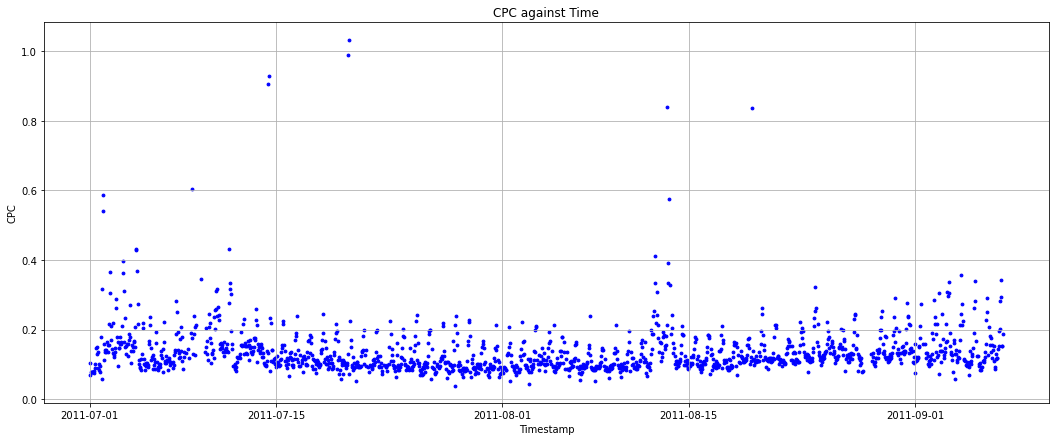

In [11]:
# plot scatter plot 
fig, ax = plt.subplots()
fig.set_size_inches(18, 7)
ax.set_title("CPC against Time")
ax.grid(b=True)
ax.set_xlabel("Timestamp")
ax.set_ylabel("CPC")
ax.scatter(
    x=df_train['timestamp'],
    y=df_train['value'],
    s=8, color='blue', label='Data');

It seems like there are indeed certain unusual spikes in the data. One challenge with anomaly detection is that we can never have the "right answer" as criteria for a data to be considered as an anomaly are defined by organisations. This means that it is different in a case-by-case basis. 

Fortunately, we already have the list of anomalies availabel to us in this case. Let us import the data in 'labels.json'.

In [12]:
# display anomalies in json file
list_of_train_anomalies = labeled_anomalies[training_file_name]

print("The list of anomalies as recorded in 'labels.json' file is:")
print("\n")
print(list_of_train_anomalies)

The list of anomalies as recorded in 'labels.json' file is:


['2011-07-14 10:15:01', '2011-07-20 10:15:01', '2011-08-13 10:15:01']


We see that there are 3 anomalies labeled in the dataset. To make the process of model development easier, we will create another column named "anomaly_label" and give it a value of 1 for anomalous data and 0 for normal data. 

In [13]:
# insert new column and write 1 if sample is anomaly else 0
df_train['anomaly_label'] = df_train['timestamp'].isin(labeled_anomalies[training_file_name]).astype(int)
df_test['anomaly_label'] = df_test['timestamp'].isin(labeled_anomalies[test_file_name]).astype(int)

We will now highlight which of these data are anomalies in the scatter plot. This gives us a better sense of why that particular instance(s) are anomalous.

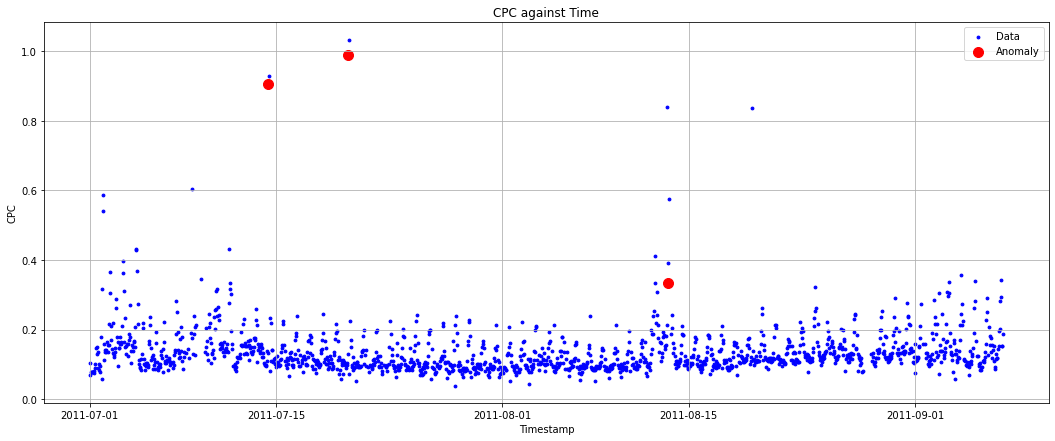

In [14]:
# plot scatter plot 
fig, ax = plt.subplots()
fig.set_size_inches(18, 7)
ax.set_title("CPC against Time")
ax.grid(b=True)
ax.set_xlabel("Timestamp")
ax.set_ylabel("CPC")
ax.scatter(
    x=df_train['timestamp'],
    y=df_train['value'],
    s=8, color='blue', label='Data')
ax.scatter(x=df_train['timestamp'][df_train['anomaly_label']==1], 
           y=df_train['value'][df_train['anomaly_label']==1], 
           s=100, c='red', label='Anomaly')
ax.legend();

We can see that the 3 anomalies are dispersed at different points in time and are quite far apart. Most of them appeared to have a sudden spike in terms of value when compared to the neighboring data.

## <a name="model-dev">Model Development</a>
After performing some basic analytics on the dataset at hand, we will start to build deep learning model to classify time series for this dataset. We will be guiding you through the process of developing a LSTM model using `PyTorch`.

LSTM is a variant of recurrent neural network (RNN). RNNs have loops in the network that, theoretically, allows for past information to persist. This feature helps to overcome one of the shortcomings of a traditional neural network, where it is ineffective in modeling sequential data.

RNNs have been applied successfully in many tasks involving sequential data, such as language modeling, machine translation, etc. However, there are certain downsides to a vanilla RNN. RNN is notoriously known for its inability to handle long-term dependencies, and result in vanishing gradient issue. This is not a good news for a network that was initially designed to for such task.

Therefore, LSTMs is popularizeed over RNNs in order to more effectively model sequential data. Its combination of forget gate, input gate, memory gate and hidden cell along with other model architecture details enable it to more effectively handle long-term dependencies over RNN. We will be guiding you on how to build a LSTM model in this tutorial.

If you are interested to find out more about LSTM, Colah provides a great explanation of LSTM, which can be found [here](https://colah.github.io/posts/2015-08-Understanding-LSTMs/).

Before we start building the model though, we have to first prepare our data into the format that can be fed into LSTM model.

In [15]:
# extract the features and reshape to 2D array
x_train = df_train.value.to_numpy().reshape(-1, 1)
x_test = df_test.value.to_numpy().reshape(-1, 1)

It is vital to prepare our data into a form that is ingestible by our model, and for LSTM model it will usually be transformed into the shape of ``(N, L, C)``, where N denotes batch size, C denotes number of channels, and L denotes length of signal sequence. The transformation process is done alongside the transformation of NumPy ``ndarray`` into Torch ``FloatTensor``. A customized class inheriting from PyTorch's ``Dataset`` class is written to return a ``Dataset`` instance.

In [16]:
# writing customized Dataset
class CPCDataset(Dataset):
    """
    Convert input data into torch FloatTensor. 
    Inherit Dataset class. Return length of instance when len method is called and return specific sample
    of data when indexed.
    """    
    def __init__(self, data: np.ndarray, size: int):
        self.sequences = torch.FloatTensor(data).unfold(0, size, size)

    def __len__(self):
        return self.sequences.size(0)
        
    def __getitem__(self, index):
        x = self.sequences[index]
        return x
    
# instantiating CPCDataset instance using sequence length of 24
train_torch_dataset = CPCDataset(x_train, 24)
test_torch_dataset = CPCDataset(x_test, 24)

Next, we will generate `DataLoader` instance using the `Dataset` objects. One parameter needed to be specified here is the `batch_size` parameter. 

In [17]:
# define batch size of 32
batch_size = 32

# define train and test DataLoader
train_loader = DataLoader(train_torch_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_torch_dataset, batch_size, shuffle=False)
dataloaders = {'train': train_loader,
               'test': test_loader
              }

Then, it is time to define the model architecture of our LSTM and instantiating it.

In [18]:
# define model architecture for model
class LSTM(nn.Module):

    def __init__(self, 
                 input_size: int, 
                 hidden_size: int, 
                 out_size: int,
                 num_layers: int,
                ):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, out_size)
        self.initialize_hidden_state()
        
    def forward(self, x):
        out, self.hidden_state = self.lstm(x.view(len(x), 1, -1), self.hidden_state)
        self.hidden_state = tuple([h.detach() for h in self.hidden_state])
        out = out.view(len(x), -1)
        out = self.linear(out)
        return out
        
    def initialize_hidden_state(self):
        self.hidden_state = (
            torch.zeros((self.num_layers, 1, self.hidden_size)),
            torch.zeros((self.num_layers, 1, self.hidden_size)))
        
model = LSTM(input_size=1, hidden_size=32, out_size=1, num_layers=1)

We are still not done yet. We need to configure some hyperparameters before we can conduct model training.  Do note that the values shown here are not the only options that you can use. Hyperparameter tuning is a trial-and-error process. You will have to find out for yourself what kind of hyperparameter works best for different datasets and model.

In [19]:
# set hyperparameters for model
epochs = 200
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

Let's write some code to perform model training according to the number of epochs. For each epoch, model training and validation will be carried out.

In [20]:
# model training and validation
loss_score = {'train': [], 'test': []}
for epoch in range(epochs):
    # uncomment to print epoch number
#     print(f'Epoch {epoch+1}/{epochs}')
    for phase in ['train', 'test']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        loss_cumsum = 0.0
        total_iterations = 0.0

        for i, sequence in enumerate(dataloaders[phase]):
            value = sequence
            with torch.set_grad_enabled(phase == 'train'):
                out = model(value.view(-1, 1))
                loss = criterion(out.view(-1), value.view(-1))

                # if the current phase is training phase, then do backward propagation
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            loss_cumsum += loss.item() * out.size(0)
            total_iterations += out.size(0)

        epoch_loss = loss_cumsum / total_iterations
        # uncomment to print training and validation loss
#         print(f'{phase.upper()} Loss: {epoch_loss}')
        loss_score[phase].append(epoch_loss)

Note that we have stored the loss score during model training and validation for each epoch. We will plot a line chart of loss score (y-axis) against number of epochs (x-axis). This plot will help us to check whether the model is converging.

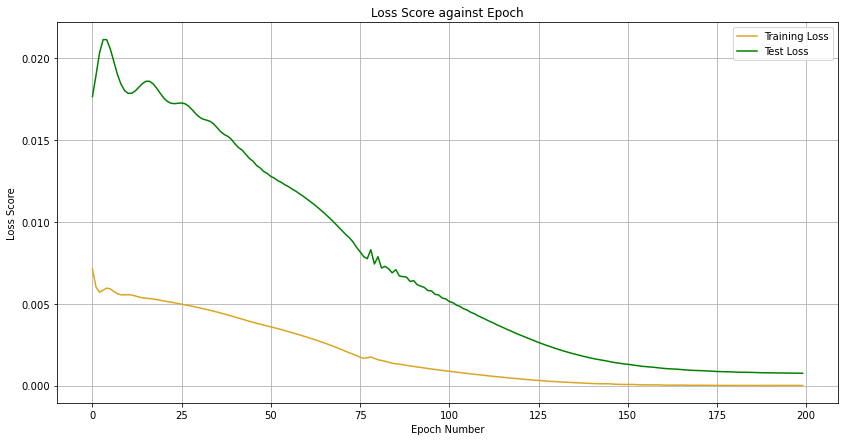

In [21]:
# plot loss score for training and validation loop
fig, ax = plt.subplots()
fig.set_size_inches(14, 7)
ax.set_title("Loss Score against Epoch")
ax.grid(b=True)
ax.set_xlabel("Epoch Number")
ax.set_ylabel("Loss Score")
ax.plot(loss_score['train'], color='goldenrod', label='Training Loss')
ax.plot(loss_score['test'], color='green', label='Test Loss')
ax.legend();

We can see from the loss score plot above that the model is converging as there are no sudden upward spikes at the last few epochs. Our model is ready to be tested to check for its performance on unseen data.

## <a name="evaluation">Evaluation</a>
Since this is a classification task, we will be using the following metrics for model evaluation:
* accuracy
* precision
* recall
* f1-score

We will examine the performance of the model on both the training and test set. The steps to examine the model is as follows:

1. Prepare input data into format that is ingestible by the model
2. Set model to `eval` mode
3. Feed input data into the model and generate reconstructed values
4. Compare each reconstructed value against the original value using suitable loss criterion to generate a list of reconstruction errors
5. Based on the reconstruction errors, generate a threshold. In this notebook, static threshold of 3 S.D. is used, which means that reconstruction errors that is higher than 3 standard deviation of mean value is considered as anomaly.
6. Using the detected anomalies classified by the threshold criteria, compare and compute confusion matrix, precision, recall and F2-score
7. Display scatter plot indicating which are the anomalies detected by the model

The following codes are the implementations for the steps mentioned above.

In [22]:
# prepare data   
actual_values = torch.Tensor(df_train['value'].values.astype(np.float32).flatten())
model.eval()

# reconstruct values based on input data
with torch.no_grad():
    reconstructed_values = model(actual_values)

# return a list of reconstruction errors for each reconstructed value 
reconstruction_errors = []
for actual_value, reconstructed_value in zip(actual_values.view(-1), reconstructed_values.view(-1)):
    reconstruction_errors = np.append(reconstruction_errors, 
                                      criterion(actual_value, reconstructed_value).numpy().flatten())

# compute static threshold
error_threshold = np.mean(reconstruction_errors) + 3*np.std(reconstruction_errors)

# return anomaly indices in list 
anomalies_indices = []
for i in range(len(reconstruction_errors)):
    is_anomaly = reconstruction_errors[i] > error_threshold
    if is_anomaly:
        anomalies_indices.append(i)


In [23]:
def compute_metrics(
    ground_truth: pd.DataFrame, anomalies_idxs: list, train: bool = True
    ):
    """Return confusion matrix, precision, recall and F2-score of model by comparing detected anomalies and ground truth."""
    
    predictions = pd.DataFrame(
        index=range(len(ground_truth)), 
        columns=['anomaly_predicted']
    )
    predictions['anomaly_predicted'] = 0
    predictions.iloc[anomalies_idxs] = 1
    
    # Calculation of the confusion matrix can be done using pandas
    confusion_matrix = pd.crosstab(
        ground_truth.loc[:, 'anomaly_label'],
        predictions['anomaly_predicted'], 
        margins=True
    )
    precision, recall, f2, _ = precision_recall_fscore_support(
        ground_truth.loc[:, 'anomaly_label'],
        predictions['anomaly_predicted'], 
        beta=2., 
        average='binary',
        zero_division=0
    )
    
    # display output
    print("CONFUSION MATRIX:")
    print(confusion_matrix)
    if train:
        print(f'\n\nMODEL PERFORMANCE METRICS ON TRAINING SET:\n\nPrecision: {precision:.3f}\n' 
              f'Recall: {recall:.3f}\n' 
              f'F2 score: {f2:.3f}')
    else:
        print(f'\n\nMODEL PERFORMANCE METRICS ON TEST SET:\nPrecision: {precision:.3f}\n' 
              f'Recall: {recall:.3f}\n' 
              f'F2 score: {f2:.3f}')        
        
    return confusion_matrix, precision, recall, f2

train_conf_matrix, *train_metrics = compute_metrics(df_train, anomalies_indices)

CONFUSION MATRIX:
anomaly_predicted     0  1   All
anomaly_label                   
0                  1532  3  1535
1                     1  2     3
All                1533  5  1538


MODEL PERFORMANCE METRICS ON TRAINING SET:

Precision: 0.400
Recall: 0.667
F2 score: 0.588


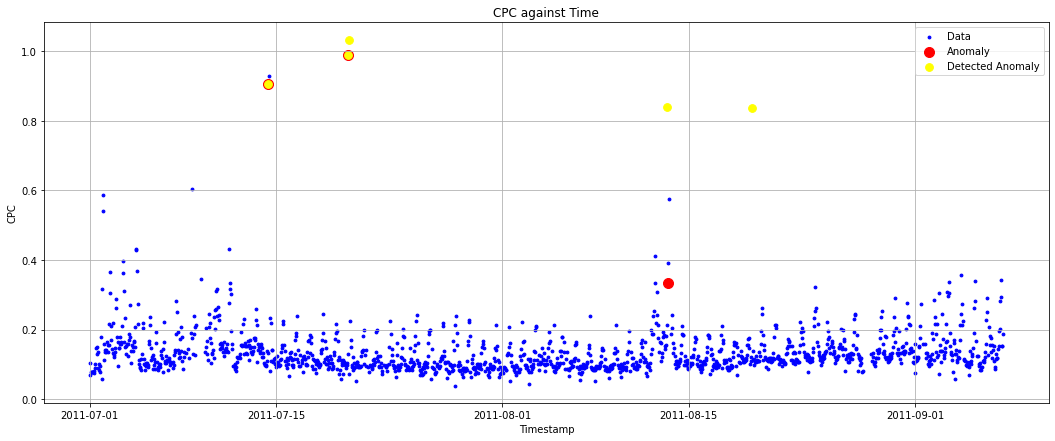

In [24]:
# plot scatter plot 
fig, ax = plt.subplots()
fig.set_size_inches(18, 7)
ax.set_title("CPC against Time")
ax.grid(b=True)
ax.set_xlabel("Timestamp")
ax.set_ylabel("CPC")
ax.scatter(
    x=df_train['timestamp'],
    y=df_train['value'],
    s=8, color='blue', label='Data')
ax.scatter(x=df_train['timestamp'][df_train['anomaly_label']==1], 
           y=df_train['value'][df_train['anomaly_label']==1], 
           s=100, c='red', label='Anomaly')
ax.scatter(x=df_train['timestamp'].iloc[anomalies_indices], 
           y=df_train['value'].iloc[anomalies_indices], 
           s=60, c='yellow', label='Detected Anomaly')
ax.legend();

Our model seems to have a good performance, where it was able to detect all 3 anomalies and achieve a recall score of 1.0. In real-world application, false negatives are costlier compared to false positives, so emphasis will be given to an anomaly detection model's ability to achieve a high recall score.

Next, we will examine the model performance against test data.

In [25]:
# prepare data   
test_values = torch.Tensor(df_test['value'].values.astype(np.float32).flatten())
model.eval()

# reconstruct values based on input data
with torch.no_grad():
    reconstructed_values = model(test_values)

# return a list of reconstruction errors for each reconstructed value 
reconstruction_errors = []
for test_value, reconstructed_value in zip(test_values.view(-1), reconstructed_values.view(-1)):
    reconstruction_errors = np.append(reconstruction_errors, 
                                      criterion(test_value, reconstructed_value).numpy().flatten())

# compute static threshold
error_threshold = np.mean(reconstruction_errors) + 3*np.std(reconstruction_errors)

# return anomaly indices in list 
anomalies_indices = []
for i in range(len(reconstruction_errors)):
    is_anomaly = reconstruction_errors[i] > error_threshold
    if is_anomaly:
        anomalies_indices.append(i)

test_conf_matrix, *test_metrics = compute_metrics(df_test, anomalies_indices)        

CONFUSION MATRIX:
anomaly_predicted     0  1   All
anomaly_label                   
0                  1639  1  1640
1                     1  2     3
All                1640  3  1643


MODEL PERFORMANCE METRICS ON TRAINING SET:

Precision: 0.667
Recall: 0.667
F2 score: 0.667


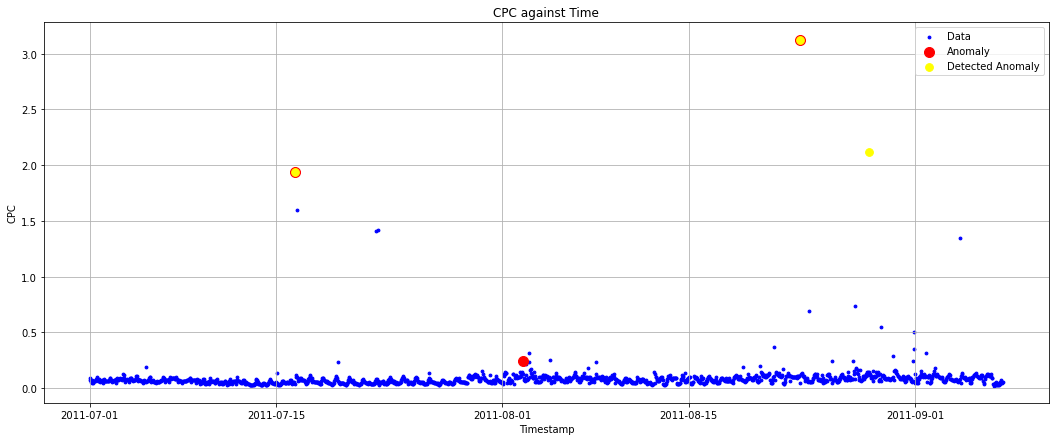

In [26]:
# plot scatter plot 
fig, ax = plt.subplots()
fig.set_size_inches(18, 7)
ax.set_title("CPC against Time")
ax.grid(b=True)
ax.set_xlabel("Timestamp")
ax.set_ylabel("CPC")
ax.scatter(
    x=df_test['timestamp'],
    y=df_test['value'],
    s=8, color='blue', label='Data')
ax.scatter(x=df_test['timestamp'][df_test['anomaly_label']==1], 
           y=df_test['value'][df_test['anomaly_label']==1], 
           s=100, c='red', label='Anomaly')
ax.scatter(x=df_test['timestamp'].iloc[anomalies_indices], 
           y=df_test['value'].iloc[anomalies_indices], 
           s=60, c='yellow', label='Detected Anomaly')
ax.legend();

The model is able to detect 2 out of 3 anomalies for test set. This seems not so satisfactory, however upon closer inspection, the second anomaly actually quite resembles what a normal data should look like. This could explain why the model fails to detect it as an anomaly. However, measures should be taken to how to further improve this model so that it can have a better performance.

The following will be Exercise section.

## <a name="exercise">Exercise</a>

This exercise section is attached for you to practice and hone your skills. Try your best effort to complete it without referring to the solution.

### Notebook Configurations
You can import any module that you wish to use for this exercise. However, if you run the cells from the start of this notebook, most probably all the modules which you need had already been imported at this point.

In [27]:
# import modules
### BEGIN SOLUTION


### END SOLUTION

### Dataset
**INSTRUCTIONS**: Please use the "cpc_results_4" as the training dataset and "cpc_results_3" as the test dataset for the remainder of this exercise. 

In [28]:
# path specification
### BEGIN SOLUTION
dataset_dir_path = Path().resolve().parent.parent/'datasets'
label_dir_path = dataset_dir_path/'labels'
data_dir_path = dataset_dir_path/'cpc'
training_file_name = 'cpc_results_4.csv' 
test_file_name = 'cpc_results_3.csv' 
### END SOLUTION

# import dataset
### BEGIN SOLUTION
df_train = pd.read_csv(data_dir_path/training_file_name)
df_test = pd.read_csv(data_dir_path/test_file_name)
### END SOLUTION

# import label
### BEGIN SOLUTION
labels_file_path = label_dir_path/'labels.json'
with open(labels_file_path, 'r') as f:
    labeled_anomalies = json.load(f)
### END SOLUTION

### Basic Analytics
**INSTRUCTIONS**: Perform some basic analytics on the dataset by following the guidelines that are provided in each cell.

In [29]:
# compute info on training dataset
### BEGIN SOLUTION
df_train.info()
### END SOLUTION

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1643 entries, 0 to 1642
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  1643 non-null   object 
 1   value      1643 non-null   float64
dtypes: float64(1), object(1)
memory usage: 25.8+ KB


In [30]:
# inspect the 'timestamp' column
### BEGIN SOLUTION
df_train['timestamp'].head(10)
### END SOLUTION

0    2011-07-01 00:15:01
1    2011-07-01 01:15:01
2    2011-07-01 02:15:01
3    2011-07-01 03:15:01
4    2011-07-01 04:15:01
5    2011-07-01 05:15:01
6    2011-07-01 06:15:01
7    2011-07-01 07:15:01
8    2011-07-01 08:15:01
9    2011-07-01 09:15:01
Name: timestamp, dtype: object

As suspected, the column stores timestamp information of each sample. We can convert it to the proper data type, which is `datetime` data type.

In [31]:
# convert 'timestamp' column data type to datetime
### BEGIN SOLUTION
df_train['timestamp'] = pd.to_datetime(df_train['timestamp'], infer_datetime_format=True)
df_test['timestamp'] = pd.to_datetime(df_test['timestamp'], infer_datetime_format=True)
### END SOLUTION

In [32]:
# return maximum value of 'timestamp' column
### BEGIN SOLUTION
df_train['timestamp'].max()
### END SOLUTION

Timestamp('2011-09-07 14:15:01')

In [33]:
# return descriptive statistics of 'value' column
### BEGIN SOLUTION
df_train.value.describe()
### END SOLUTION

count    1643.000000
mean        0.086439
std         0.128977
min         0.023884
25%         0.055185
50%         0.072820
75%         0.095459
max         3.126852
Name: value, dtype: float64

In [34]:
# display anomalies in json file
### BEGIN SOLUTION
list_of_train_anomalies = labeled_anomalies[training_file_name]
### END SOLUTION

print("The list of anomalies as recorded in 'labels.json' file is:")
print("\n")
print(list_of_train_anomalies)

The list of anomalies as recorded in 'labels.json' file is:


['2011-07-16 09:15:01', '2011-08-02 12:15:01', '2011-08-23 08:15:01']


In [35]:
# insert new 'anomaly_label' column and write 1 if sample is anomaly else 0
### BEGIN SOLUTION
df_train['anomaly_label'] = df_train['timestamp'].isin(labeled_anomalies[training_file_name]).astype(int)
df_test['anomaly_label'] = df_test['timestamp'].isin(labeled_anomalies[test_file_name]).astype(int)
### END SOLUTION

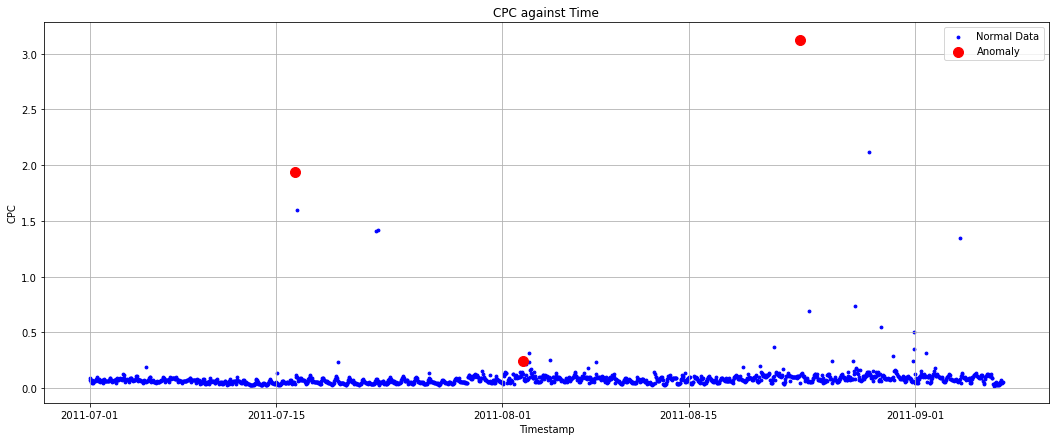

In [36]:
# plot scatter plot of 'value' against 'timestamp' with legend indicationg normal data and anomaly
### BEGIN SOLUTION
fig, ax = plt.subplots()
fig.set_size_inches(18, 7)
ax.set_title("CPC against Time")
ax.grid(b=True)
ax.set_xlabel("Timestamp")
ax.set_ylabel("CPC")
ax.scatter(
    x=df_train['timestamp'],
    y=df_train['value'],
    s=8, color='blue', label='Normal Data')
ax.scatter(x=df_train['timestamp'][df_train['anomaly_label']==1], 
           y=df_train['value'][df_train['anomaly_label']==1], 
           s=100, c='red', label='Anomaly')
ax.legend();
### END SOLUTION

### Model Development
**INSTRUCTIONS**: Prepare the input data and define your own LSTM model. Implement training and validation loop at each epoch.

In [46]:
# extract the features and reshape to 2D array
### BEGIN SOLUTION
x_train = df_train.value.to_numpy().reshape(-1, 1)
x_test = df_test.value.to_numpy().reshape(-1, 1)
### END SOLUTION

In [47]:
# writing customized Dataset
### BEGIN SOLUTION
class CPCDataset(Dataset):
    """
    Convert input data into torch FloatTensor. 
    Inherit Dataset class. Return length of instance when len method is called and return specific sample
    of data when indexed.
    """    
    def __init__(self, data: np.ndarray, size: int):
        self.sequences = torch.FloatTensor(data).unfold(0, size, size)

    def __len__(self):
        return self.sequences.size(0)
        
    def __getitem__(self, index):
        x = self.sequences[index]
        return x
### END SOLUTION
    
# instantiating Dataset instance using sequence length of 24
### BEGIN SOLUTION
train_torch_dataset = CPCDataset(x_train, 24)
test_torch_dataset = CPCDataset(x_test, 24)
### END SOLUTION

In [48]:
# define train and test DataLoader with a batch size of 128
### BEGIN SOLUTION
train_loader = DataLoader(train_torch_dataset, 128, shuffle=False)
test_loader = DataLoader(test_torch_dataset, 128, shuffle=False)
dataloaders = {'train': train_loader,
               'test': test_loader}
### END SOLUTION

In [49]:
# define model architecture for model
class LSTM(nn.Module):
    ### BEGIN SOLUTION
    def __init__(self, 
                 input_size: int, 
                 hidden_size: int, 
                 out_size: int,
                 num_layers: int,
                ):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, out_size)
        self.initialize_hidden_state()
        
    def forward(self, x):
        out, self.hidden_state = self.lstm(x.view(len(x), 1, -1), self.hidden_state)
        self.hidden_state = tuple([h.detach() for h in self.hidden_state])
        out = out.view(len(x), -1)
        out = self.linear(out)
        return out
        
    def initialize_hidden_state(self):
        self.hidden_state = (
            torch.zeros((self.num_layers, 1, self.hidden_size)),
            torch.zeros((self.num_layers, 1, self.hidden_size)))
### END SOLUTION

# instantiating LSTM model with 2 layers and hidden size of 48
### BEGIN SOLUTION
model = LSTM(input_size=1, hidden_size=48, out_size=1, num_layers=2)
### END SOLUTION

In [50]:
# set hyperparameters for model
### BEGIN SOLUTION
epochs = 200
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
### END SOLUTION

In [51]:
# implement model training and validation loop, storing loss score for training and validation phase of each epoch in a dictionary
### BEGIN SOLUTION
loss_score = {'train': [], 'test': []}
for epoch in range(epochs):
    # uncomment to print epoch number
#     print(f'Epoch {epoch+1}/{epochs}')
    for phase in ['train', 'test']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        loss_cumsum = 0.0
        total_iterations = 0.0

        for i, sequence in enumerate(dataloaders[phase]):
            value = sequence
            with torch.set_grad_enabled(phase == 'train'):
                out = model(value.view(-1, 1))
                loss = criterion(out.view(-1), value.view(-1))

                # if the current phase is training phase, then do backward propagation
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            loss_cumsum += loss.item() * out.size(0)
            total_iterations += out.size(0)

        epoch_loss = loss_cumsum / total_iterations
        # uncomment to print training and validation loss
#         print(f'{phase.upper()} Loss: {epoch_loss}')
        loss_score[phase].append(epoch_loss)
### END SOLUTION

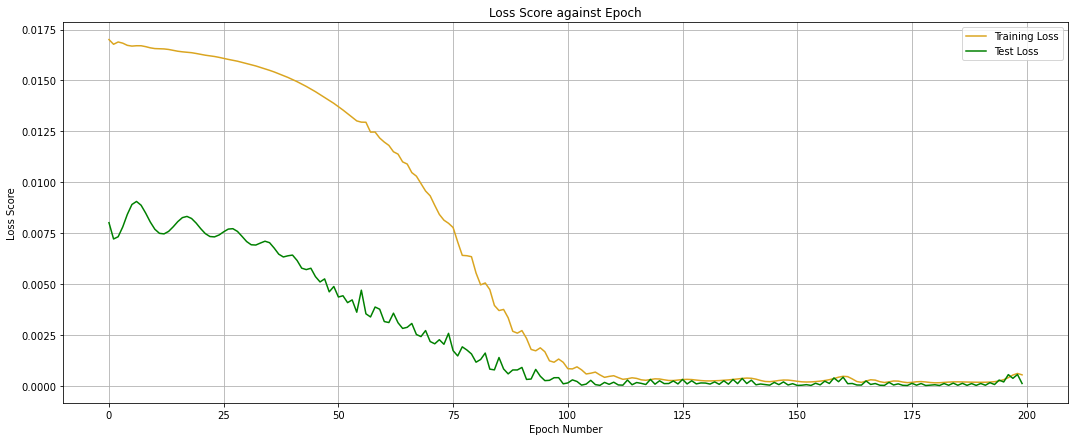

In [52]:
# plot loss score for training and validation loop
### BEGIN SOLUTION
fig, ax = plt.subplots()
fig.set_size_inches(18, 7)
ax.set_title("Loss Score against Epoch")
ax.grid(b=True)
ax.set_xlabel("Epoch Number")
ax.set_ylabel("Loss Score")
ax.plot(loss_score['train'], color='goldenrod', label='Training Loss')
ax.plot(loss_score['test'], color='green', label='Test Loss')
ax.legend();
### END SOLUTION

### Evaluation
**INSTRUCTIONS:** Follow the guidelines given in the cells to evaluate performance of model.

In [53]:
# prepare test data for model evaluation
### BEGIN SOLUTION
test_values = torch.Tensor(df_test['value'].values.astype(np.float32).flatten())
model.eval()
### END SOLUTION

# reconstruct values based on input data
### BEGIN SOLUTION
with torch.no_grad():
    reconstructed_values = model(test_values)
### END SOLUTION

# return a list of reconstruction errors for each reconstructed value 
### BEGIN SOLUTION
reconstruction_errors = []
for test_value, reconstructed_value in zip(test_values.view(-1), reconstructed_values.view(-1)):
    reconstruction_errors = np.append(reconstruction_errors, 
                                      criterion(test_value, reconstructed_value).numpy().flatten())
### END SOLUTION
    
# compute static threshold using 3 S.D. method
### BEGIN SOLUTION
error_threshold = np.mean(reconstruction_errors) + 3*np.std(reconstruction_errors)
### END SOLUTION

# return anomaly indices in list 
### BEGIN SOLUTION
anomalies_indices = []
for i in range(len(reconstruction_errors)):
    is_anomaly = reconstruction_errors[i] > error_threshold
    if is_anomaly:
        anomalies_indices.append(i)
### END SOLUTION

# compute confusion matrix, recall, precision and F2-score
### BEGIN SOLUTION
test_conf_matrix, *test_metrics = compute_metrics(df_test, anomalies_indices)        
### END SOLUTION

CONFUSION MATRIX:
anomaly_predicted     0  1   All
anomaly_label                   
0                  1528  7  1535
1                     1  2     3
All                1529  9  1538


MODEL PERFORMANCE METRICS ON TRAINING SET:

Precision: 0.222
Recall: 0.667
F2 score: 0.476


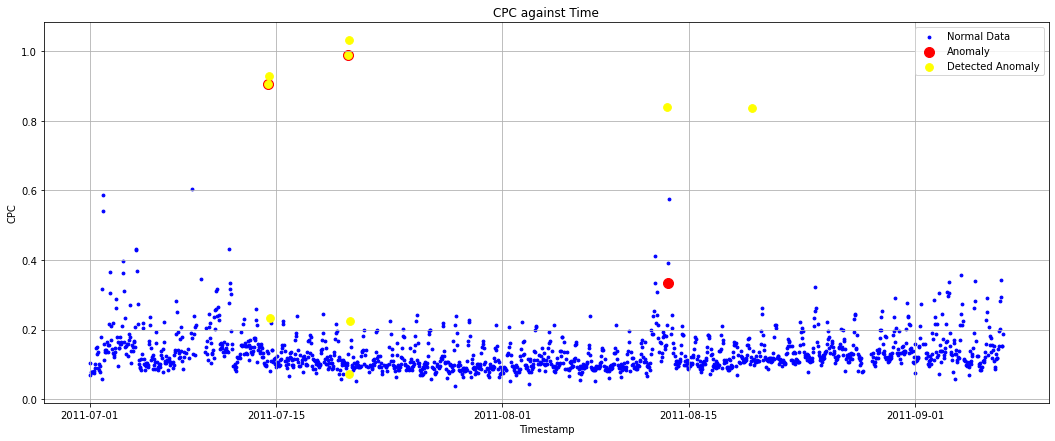

In [54]:
# plot scatter plot using legend to indicate normal data, anomaly (grouund truth) and detected anomaly
### BEGIN SOLUTION
fig, ax = plt.subplots()
fig.set_size_inches(18, 7)
ax.set_title("CPC against Time")
ax.grid(b=True)
ax.set_xlabel("Timestamp")
ax.set_ylabel("CPC")
ax.scatter(
    x=df_test['timestamp'],
    y=df_test['value'],
    s=8, color='blue', label='Normal Data')
ax.scatter(x=df_test['timestamp'][df_test['anomaly_label']==1], 
           y=df_test['value'][df_test['anomaly_label']==1], 
           s=100, c='red', label='Anomaly')
ax.scatter(x=df_test['timestamp'].iloc[anomalies_indices], 
           y=df_test['value'].iloc[anomalies_indices], 
           s=60, c='yellow', label='Detected Anomaly')
ax.legend();
### END SOLUTION

## <a name="reference">Reference</a>
1. [Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
2. [NAB Data Corpus](https://github.com/numenta/NAB/tree/master/data)

## <a name="bonus">Bonus</a>
Do you know that LSTM was first introduced in 1995, way before the popularization of the now infamous term "deep learning"? It was originally proposed by Sepp Hochreiter and Jürgen Schmidhuber. LSTM tackles the vanishing gradient problem using Constant Error Carousel (CEC) units. The first version of LSTM block consists of cells, input and output gates. You can read more about the history of LSTM [here](https://en.wikipedia.org/wiki/Long_short-term_memory).